# SystemML PySpark Recommendation Demo

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add SystemML PySpark API file.
sc.addPyFile("https://raw.githubusercontent.com/apache/incubator-systemml/3d5f9b11741f6d6ecc6af7cbaa1069cde32be838/src/main/java/org/apache/sysml/api/python/SystemML.py")

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

# Data

In [2]:
%%sh
# Download dataset
curl -O http://snap.stanford.edu/data/amazon0601.txt.gz
gunzip amazon0601.txt.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.2M  100 11.2M    0     0  1219k      0  0:00:09  0:00:09 --:--:-- 1600k
gunzip: amazon0601.txt already exists -- skipping


In [3]:
# Load data
import pyspark.sql.functions as F
dataPath = "amazon0601.txt"

X_train = (sc.textFile(dataPath)
    .filter(lambda l: not l.startswith("#"))
    .map(lambda l: l.split("\t"))
    .map(lambda prods: (int(prods[0]), int(prods[1]), 1.0))
    .toDF(("prod_i", "prod_j", "x_ij"))
    .filter("prod_i < 500 AND prod_j < 500") # Filter for memory constraints
    .cache())

max_prod_i = X_train.select(F.max("prod_i")).first()[0]
max_prod_j = X_train.select(F.max("prod_j")).first()[0]
numProducts = max(max_prod_i, max_prod_j) + 1 # 0-based indexing
print("Total number of products: {}".format(numProducts))

Total number of products: 500


# SystemML - Poisson Nonnegative Matrix Factorization (PNMF)

In [4]:
# Create SystemML MLContext
from SystemML import MLContext
ml = MLContext(sc)

In [5]:
# Define PNMF kernel in SystemML's DSL using the R-like syntax for PNMF
pnmf = """
# data & args
X = read($X)
X = X+1 # change product IDs to be 1-based, rather than 0-based
V = table(X[,1], X[,2])
size = ifdef($size, -1)
if(size > -1) {
    V = V[1:size,1:size]
}
max_iteration = as.integer($maxiter)
rank = as.integer($rank)

n = nrow(V)
m = ncol(V)
range = 0.01
W = Rand(rows=n, cols=rank, min=0, max=range, pdf="uniform")
H = Rand(rows=rank, cols=m, min=0, max=range, pdf="uniform")
losses = matrix(0, rows=max_iteration, cols=1)

# run PNMF
i=1
while(i <= max_iteration) {
  # update params
  H = (H * (t(W) %*% (V/(W%*%H))))/t(colSums(W)) 
  W = (W * ((V/(W%*%H)) %*% t(H)))/t(rowSums(H))
  
  # compute loss
  losses[i,] = -1 * (sum(V*log(W%*%H)) - as.scalar(colSums(W)%*%rowSums(H)))
  i = i + 1;
}

# write outputs
write(losses, $lossout)
write(W, $Wout)
write(H, $Hout)
"""

In [6]:
# Run the PNMF script on SystemML with Spark
ml.reset()
outputs = ml.executeScript(pnmf, {"X": X_train, "maxiter": 100, "rank": 10}, ["W", "H", "losses"])

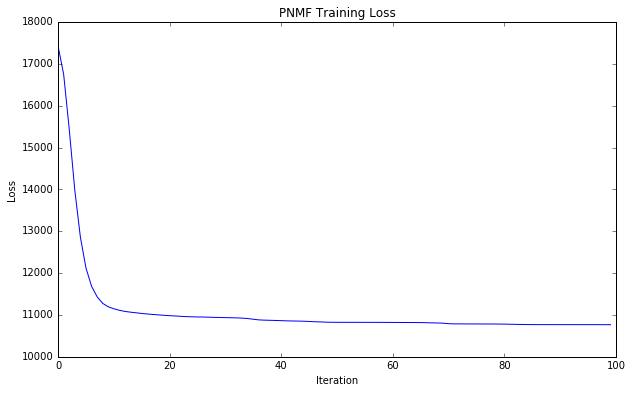

In [7]:
# Plot training loss over time
losses = outputs.getDF(sqlContext, "losses")
xy = losses.sort(losses.ID).map(lambda r: (r[0], r[1])).collect()
x, y = zip(*xy)
plt.plot(x, y)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('PNMF Training Loss')